# Face counting challenge

The method of face detection in pictures is complicated because of variability present across human faces such as pose, expression, position and orientation, skin colour, the presence of glasses or facial hair, differences in camera gain, lighting conditions, and image resolution.

Object detection is one of the computer technologies, which connected to the image processing and computer vision and it interacts with detecting instances of an object such as human faces, building, tree, car, etc. The primary aim of face detection algorithms is to determine whether there is any face in an image or not. We challenge all the hackers to participate in this computer vision challenge that aims to test skills in deep learning and object detection.

## Data


1) train.zip: Contains 2 csvs and 1 folder containing image data

- train.csv - ['Name', 'HeadCount'] (contains headcount value for each training image)
        
- bbox_train.csv - ['Name', 'width', 'height' , 'xmin', 'ymin', 'xmax', 'ymax', 'class'] (contains co-  ordinates of each head in the train image, located by the formation of a bound-box around the head)


2) test.csv - ['Name'] (contains only name of testing images)
    
3) sample_submission.csv - ['Name', 'HeadCount'] (contains format for a valid submission)


### Face Detection using Haar Cascades

Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, **“Rapid Object Detection using a Boosted Cascade of Simple Features”** in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images.

Here we will work with face detection. Initially, the algorithm needs a lot of positive images (images of faces) and negative images (images without faces) to train the classifier. Then we need to extract features from it. For this, haar features shown in below image are used. They are just like our convolutional kernel. Each feature is a single value obtained by subtracting sum of pixels under white rectangle from sum of pixels under black rectangle.

<img src="Images/haar_features.jpg" width="400" height="200">

Now all possible sizes and locations of each kernel is used to calculate plenty of features. (Just imagine how much computation it needs? Even a 24x24 window results over 160000 features). For each feature calculation, we need to find sum of pixels under white and black rectangles. To solve this, they introduced the integral images. It simplifies calculation of sum of pixels, how large may be the number of pixels, to an operation involving just four pixels. Nice, isn’t it? It makes things super-fast.

But among all these features we calculated, most of them are irrelevant. For example, consider the image below. Top row shows two good features. The first feature selected seems to focus on the property that the region of the eyes is often darker than the region of the nose and cheeks. The second feature selected relies on the property that the eyes are darker than the bridge of the nose. But the same windows applying on cheeks or any other place is irrelevant. So how do we select the best features out of 160000+ features? It is achieved by Adaboost.

<img src="Images/haar.png" width="600" height="200">

For this, we apply each and every feature on all the training images. For each feature, it finds the best threshold which will classify the faces to positive and negative. But obviously, there will be errors or misclassifications. We select the features with minimum error rate, which means they are the features that best classifies the face and non-face images. (The process is not as simple as this. Each image is given an equal weight in the beginning. After each classification, weights of misclassified images are increased. Then again same process is done. New error rates are calculated. Also new weights. The process is continued until required accuracy or error rate is achieved or required number of features are found).

Final classifier is a weighted sum of these weak classifiers. It is called weak because it alone can’t classify the image, but together with others forms a strong classifier. The paper says even 200 features provide detection with 95% accuracy. Their final setup had around 6000 features. (Imagine a reduction from 160000+ features to 6000 features. That is a big gain).

So now you take an image. Take each 24x24 window. Apply 6000 features to it. Check if it is face or not. Wow.. Wow.. Isn’t it a little inefficient and time consuming? Yes, it is. Authors have a good solution for that.

In an image, most of the image region is non-face region. So it is a better idea to have a simple method to check if a window is not a face region. If it is not, discard it in a single shot. Don’t process it again. Instead focus on region where there can be a face. This way, we can find more time to check a possible face region.

For this they introduced the concept of Cascade of Classifiers. Instead of applying all the 6000 features on a window, group the features into different stages of classifiers and apply one-by-one. (Normally first few stages will contain very less number of features). If a window fails the first stage, discard it. We don’t consider remaining features on it. If it passes, apply the second stage of features and continue the process. The window which passes all stages is a face region. How is the plan !!!

Authors’ detector had 6000+ features with 38 stages with 1, 10, 25, 25 and 50 features in first five stages. (Two features in the above image is actually obtained as the best two features from Adaboost). According to authors, on an average, 10 features out of 6000+ are evaluated per sub-window.

So this is a simple intuitive explanation of how Viola-Jones face detection works. Read paper for more details or check out the references in Additional Resources section.


## Computer Graphics | The RGB color model

The RGB color model is one of the most widely used color representation method in computer graphics. It use a color coordinate system with three primary colors:

**R(red), G(green), B(blue)**

Each primary color can take an intensity value ranging from 0(lowest) to 1(highest). Mixing these three primary colors at different intensity levels produces a variety of colors. The collection of all the colors obtained by such a linear combination of red, green and blue forms the cube shaped RGB color space. 

<img src="Images/rgb.png" width="600" height="200">

The corner of RGB color cube that is at the origin of the coordinate system corresponds to black, whereas the corner of the cube that is diagonally opposite to the origin represents white. The diagonal line connecting black and white corresponds to all the gray colors between black and white, which is also known as gray axis.

In the RGB color model, an arbitrary color within the cubic color space can be specified by its color coordinates: (r, g.b).

<ins>Example:</ins>

**(0, 0, 0) for black, (1, 1, 1) for white, 
(1, 1, 0) for yellow, (0.7, 0.7, 0.7) for gray**

Color specification using the RGB model is an additive process. We begin with black and add on the appropriate primary components to yield a desired color. The concept RGB color model is used in Display monitor. On the other hand, there is a complementary color model known as CMY color model. The CMY color model use a subtraction process and this concept is used in the printer.

In CMY model, we begin with white and take away the appropriate primary components to yield a desired color.

<ins>Example:</ins>

If we subtract red from white, what remains consists of green and blue which is cyan. The coordinate system of CMY model use the three primaries’ complementary colors: 

<img src="Images/rgbexample.png" width="600" height="200">


**Import the libraries**

In [69]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

Let's read in an image from the train file

In [167]:
img_rgb = cv2.imread("Images/detect.jpg",1)
img_g = cv2.imread("Images/detect.jpg",0)

The 1 in "imread" reads the image in RGB (red, green, blue), which is the coloured format.

0 reads the images as gray scale, either black or white.

In [133]:
print(img_rgb.shape)
print(img_g.shape)

(427, 640, 3)
(407, 612)


In [134]:
print(type(img_rgb))
print(type(img_g))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Notice the shape of img_rgb, it has **407 rows** and **612 columns** and **3 channels** (the colour channels)

The images are also represented as a numpy array.

## Viewing the images

<ins>What does [::-1] do? </ins>

Assuming **a** is a string. The Slice notation in python has the syntax -

list[start:stop:step]

So, when you do a[::-1], it starts from the end towards the first taking each element. So it reverses a. This is applicable for lists/tuples as well.

a = '1234'

a[::-1]

answer:'4321'

With respect to images, it goes through all the colour channels to make that the original image is displayed.

**Coloured image**

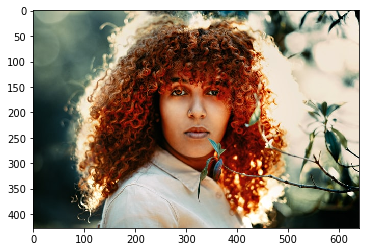

In [150]:
plt.imshow(img_rgb[:,:,::-1])
plt.show()

**Greyscale image**

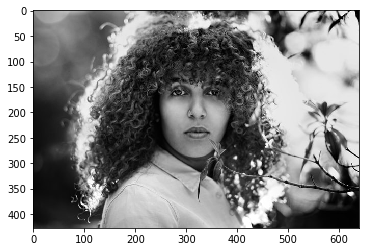

In [151]:
plt.imshow(img_g[:,:], cmap="gray")
plt.show()

## Resizing images

Here we resizee the image to **800 by 800** (it used to be 407 by 612)

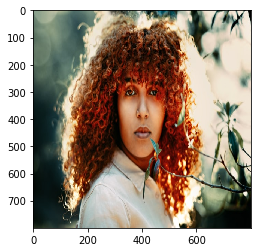

In [137]:
resized_image = cv2.resize(img_rgb, (800,800))
plt.imshow(resized_image[:,:,::-1])
plt.show()

Clearly is not proportional or symmetrical compared to the original image. We can increase and decrease the resized image by a desired ratio to the original image.

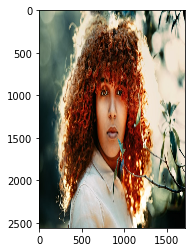

In [152]:
resized_image = cv2.resize(img_rgb, (int(img_rgb.shape[0]*4), int(img_rgb.shape[1]*4)))
plt.imshow(resized_image[:,:,::-1])
plt.show()

## Haar-cascade Detection in OpenCV

OpenCV comes with a trainer as well as detector. If you want to train your own classifier for any object like car, planes etc. you can use OpenCV to create one. Its full details are given here: Cascade Classifier Training.

Here we will deal with detection. **OpenCV already contains many pre-trained classifiers for face, eyes, smile etc.** Those XML files are stored in opencv/data/haarcascades/ folder. Let’s create face and eye detector with OpenCV.

First we need to load the required XML classifiers. Then load our input image (or video) in grayscale mode.

In [153]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

Next we have to convert our image to gray scale

In [154]:
gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

In [174]:
faces = face_cascade.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 5)

This function detects the actual face and is the key part of our code, so let’s go over the options:

1) The **detectMultiScale function** is a general function that detects objects. Since we are calling it on the face cascade, that’s what it detects.

2) The first option is the grayscale image.

3) The second is the **scaleFactor** Since some faces may be closer to the camera, they would appear bigger than the faces in the back. The scale factor compensates for this. A scaleFactor of 1.1 decreases the shape value by 10%, until the face is found. The smaller this value, the greater is the accuracy. The scaleFactor must be greater than 1.

4) The detection algorithm uses a moving window to detect objects. minNeighbors defines how many objects are detected near the current one before it declares the face found. minSize, meanwhile, gives the size of each window.

It's a method to search for face rectangle co-ordinates.


In [175]:
for (x,y,w,h) in faces:
    img = cv2.rectangle(img_rgb,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

The function "rectangle" is used to create the face rectangle. img_rgb is the image object. 

- (x,y) and (x+w. y+h) are the co-ordinates of the face rectangle.

- (255,0,0) is just the colour of the rectangle outline.

- 2 is the width of the rectangle.

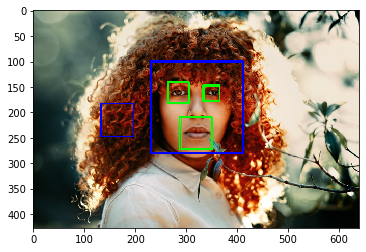

In [176]:
plt.imshow(img[:,:,::-1])
plt.show()

In [177]:
print("The Haar-cascade algorithm detects", len(faces), "faces")

The Haar-cascade algorithm detects 2 faces


The algortihm picks up a face in the womens hair. Clearly that block of hair isn't a face, but we can see why the function might think it should be. Focusing in, we notice that the block of hair has two dark spots which might be misrepresented as eyes. Let's see if we can fix this by adjusting some of the parameters. I'll change the scaleFactor from 1.1 to 1.5 (so it's more lenient).



In [178]:
img_rgb = cv2.imread("Images/detect.jpg",1)

In [179]:
faces_new = face_cascade.detectMultiScale(gray, scaleFactor = 1.5, minNeighbors = 5)

In [180]:
for (x,y,w,h) in faces_new:
    img_new = cv2.rectangle(img_rgb,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img_new[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

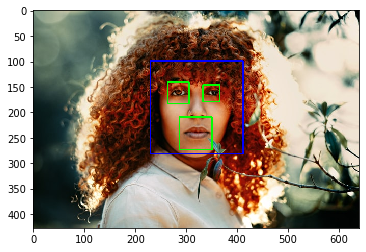

In [181]:
plt.imshow(img_new[:,:,::-1])
plt.show()

In [173]:
print("The Haar-cascade algorithm detects", len(faces_new), "face")

The Haar-cascade algorithm detects 1 face


Much better, however, it still detects her mouth as an eye. 

## Resources

**Face detection**

https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1

**Open CV tutorial**

https://www.youtube.com/watch?v=-ZrDjwXZGxI

https://www.youtube.com/watch?v=WQeoO7MI0Bs

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html

https://realpython.com/face-recognition-with-python/

 
**RGB**

https://www.geeksforgeeks.org/computer-graphics-the-rgb-color-model/

**Matplotlib images tutorial**

https://matplotlib.org/tutorials/introductory/images.html#sphx-glr-tutorials-introductory-images-py
